<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/pramurta/start_1b_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part B: Regression Problem**

In [3]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup, Flatten

In [6]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [7]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


# Question 1

**Part A**

Reasons for not randomly splitting

In [8]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

**Part B**

The cell below preprocesses the data by encoding the numerical and categorical features and concatenating the layers

In [9]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)





# Categorical features encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)


flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)



# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

#Concatenated features
all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]
)

#All input features
all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]




 The cell below represents a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer

In [38]:
tf.keras.backend.clear_session()
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

Model Architecture

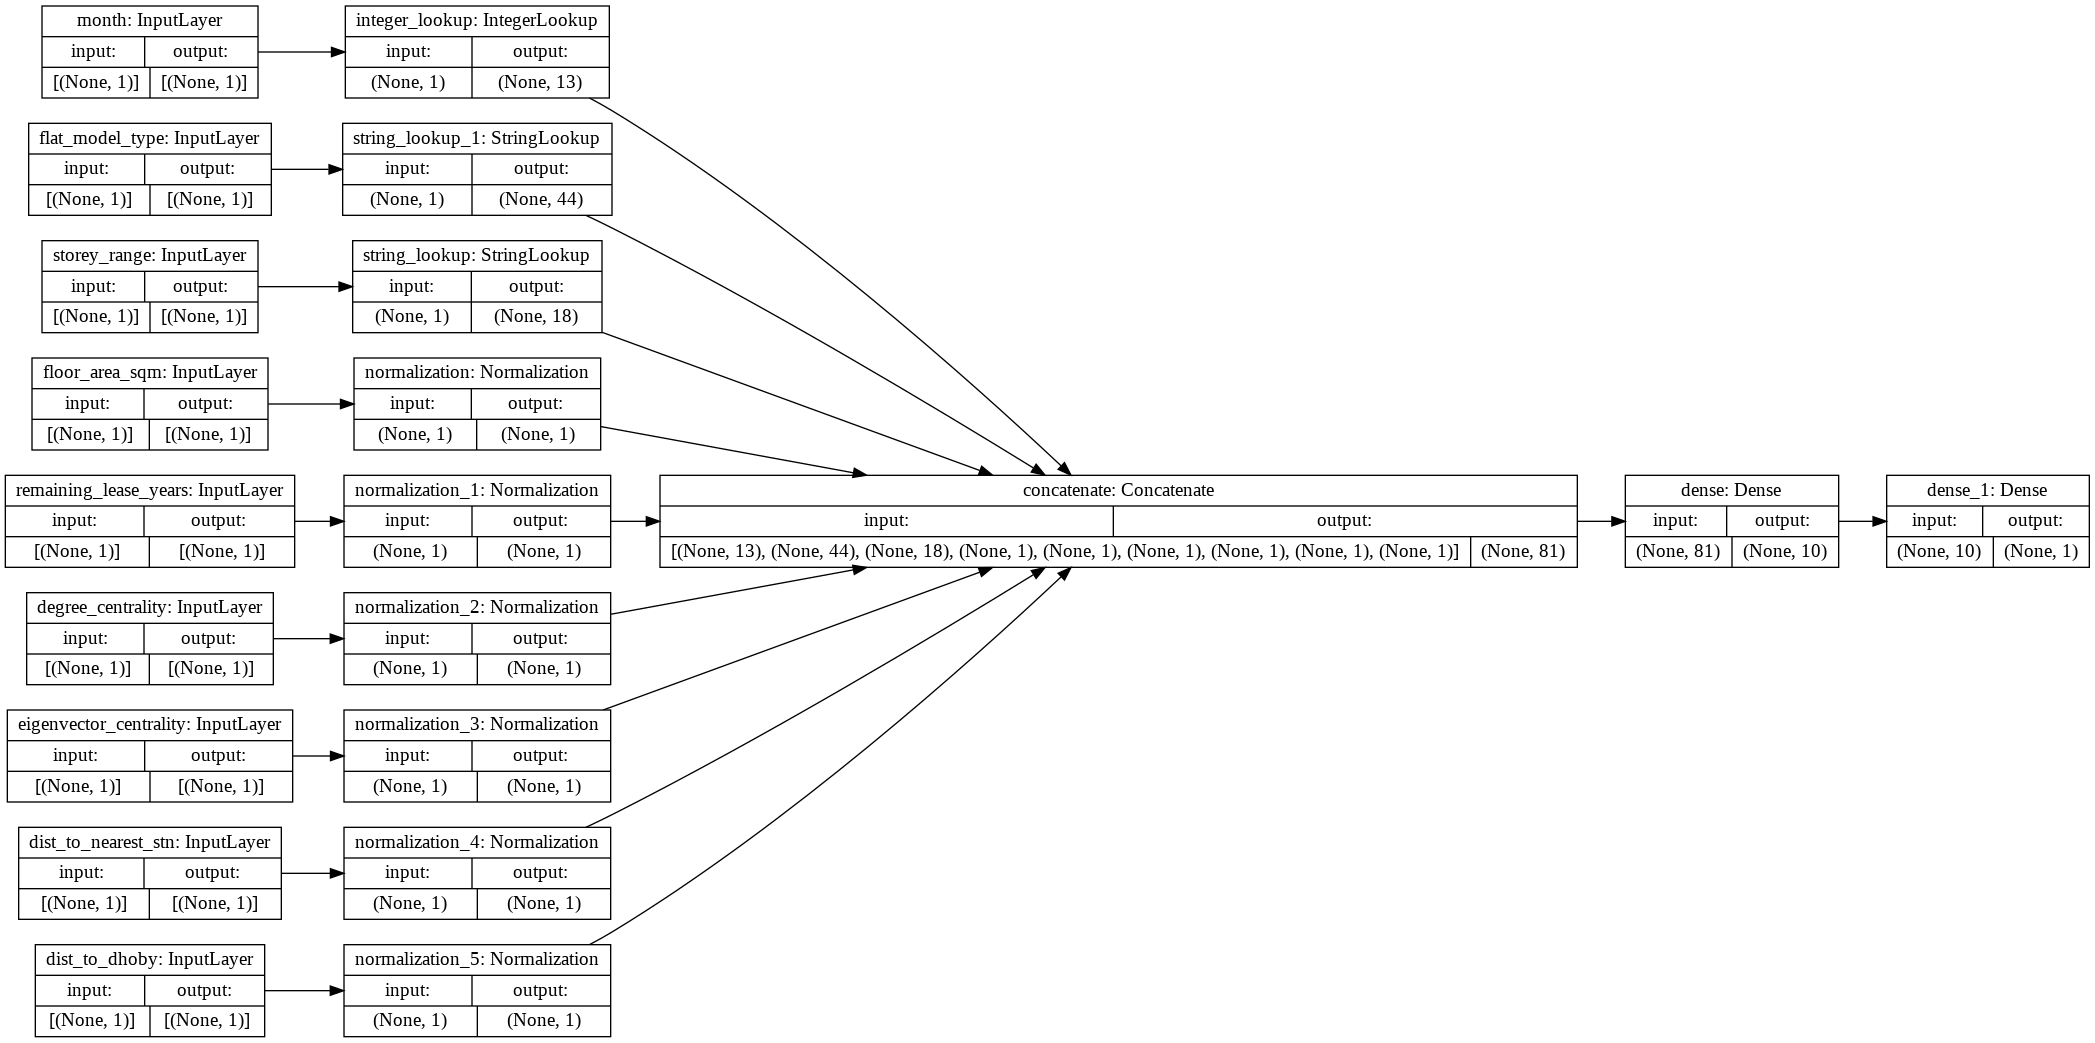

In [39]:
model = keras.Model(all_inputs, output)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

**Part C**

Model compilation

In [40]:
from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

Model Summary

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
floor_area_sqm (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

Model Training

In [42]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 5s 5ms/step - loss: 196039131136.0000 - R2: -7.4713 - val_loss: 198521274368.0000 - val_R2: -6.8109
Epoch 2/100
683/683 [==============================] - 4s 5ms/step - loss: 95786524672.0000 - R2: -3.1246 - val_loss: 71796219904.0000 - val_R2: -1.7938
Epoch 3/100
683/683 [==============================] - 5s 6ms/step - loss: 22755325952.0000 - R2: 0.0317 - val_loss: 18155538432.0000 - val_R2: 0.2934
Epoch 4/100
683/683 [==============================] - 4s 5ms/step - loss: 6633425920.0000 - R2: 0.7182 - val_loss: 9546472448.0000 - val_R2: 0.6307
Epoch 5/100
683/683 [==============================] - 4s 5ms/step - loss: 5346532352.0000 - R2: 0.7720 - val_loss: 8443978752.0000 - val_R2: 0.6743
Epoch 6/100
683/683 [==============================] - 4s 5ms/step - loss: 4934500864.0000 - R2: 0.7894 - val_loss: 8000458752.0000 - val_R2: 0.6896
Epoch 7/100
683/683 [==============================] - 4s 5ms/step - loss: 4623944192.0000 - R2: 0.8027 - 

**Part D**

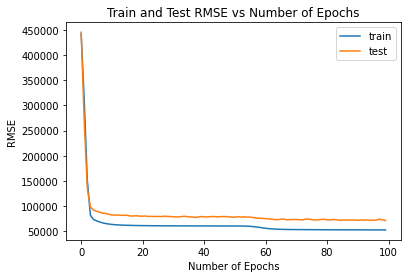

In [45]:
import math
import matplotlib.pyplot as plt

history.history['root_mean_squared_error'] = []
history.history['val_root_mean_squared_error'] = []

for i in range(len(history.history['loss'])):
    history.history['root_mean_squared_error'].append(math.sqrt(history.history['loss'][i]))

for i in range(len(history.history['val_loss'])):
    history.history['val_root_mean_squared_error'].append(math.sqrt(history.history['val_loss'][i]))

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("Train and Test RMSE vs Number of Epochs")
plt.ylabel('RMSE')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


**Part E**

In [53]:
loss = history.history['val_loss']

min_epoch_loss = 0
min_loss = float("inf")
for i,l in enumerate(loss):
    if l<min_loss:
        min_loss = l
        min_epoch_loss = i+1

print(min_epoch_loss)



100


**Therefore, the epoch with the lowest test error is 100**

In [54]:
history.history['val_R2'][min_epoch_loss-1]

0.8017891645431519

R2 score at epoch 100 is: **0.8017891645431519**

In [48]:
model.load_weights(checkpoint_filepath)

In [55]:
y_pred = model.predict(val_ds)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [56]:
y_pred_128 = np.array(y_pred[:128])

In [57]:
y_true = np.array(np.concatenate([y for x, y in val_ds], axis=0))

In [58]:
y_true_128 = np.array(y_true[:128])

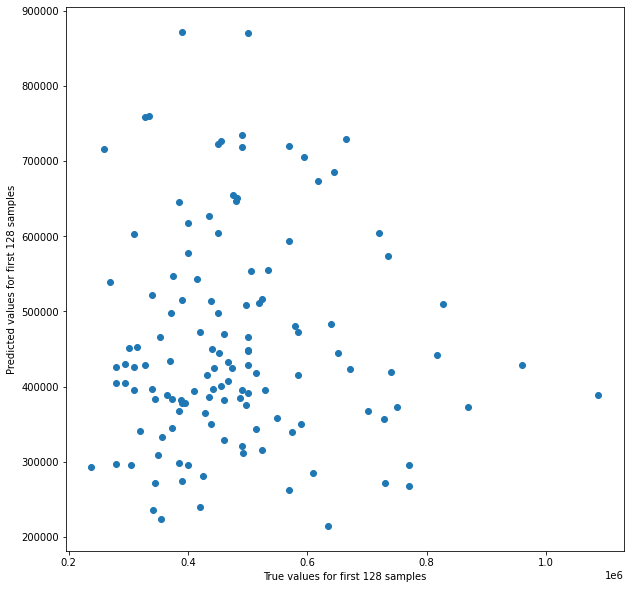

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.xlabel('True values for first 128 samples')
plt.ylabel('Predicted values for first 128 samples')
plt.scatter(y_true_128, y_pred_128)

# Question 2

**Part A**

The cell below preprocesses the data by encoding the numerical and further embedding and flattening the categorical features and finally, it concatenates all the layers

In [63]:

# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)
month_embedder = tf.keras.layers.Embedding(input_dim = month_encoded.shape[1], output_dim = (month_encoded.shape[1])//2, trainable=True)(month_encoded)
month_embedder_flattened = Flatten()(month_embedder)





# Categorical feature encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
storey_range_embedder = tf.keras.layers.Embedding(input_dim = storey_range_encoded.shape[1], output_dim = (storey_range_encoded.shape[1])//2, trainable=True)(storey_range_encoded)
storey_range_embedder_flattened = Flatten()(storey_range_embedder)


flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
flat_model_type_embedder = tf.keras.layers.Embedding(input_dim = flat_model_type_encoded.shape[1], output_dim = (flat_model_type_encoded.shape[1])//2, trainable=True)(flat_model_type_encoded)
flat_model_type_embedder_flattened = Flatten()(flat_model_type_embedder)




# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)


all_features = layers.concatenate(
    [
        month_embedder_flattened,
        flat_model_type_embedder_flattened,
        storey_range_embedder_flattened,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]
)

all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]




 The cell below represents a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer

In [66]:
# feedforward network with one hidden layer
tf.keras.backend.clear_session()
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model = keras.Model(all_inputs, output)



Model Summary

In [67]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 13)           0           month[0][0]                      
______________________________________________________________________________________________

Model Architecture

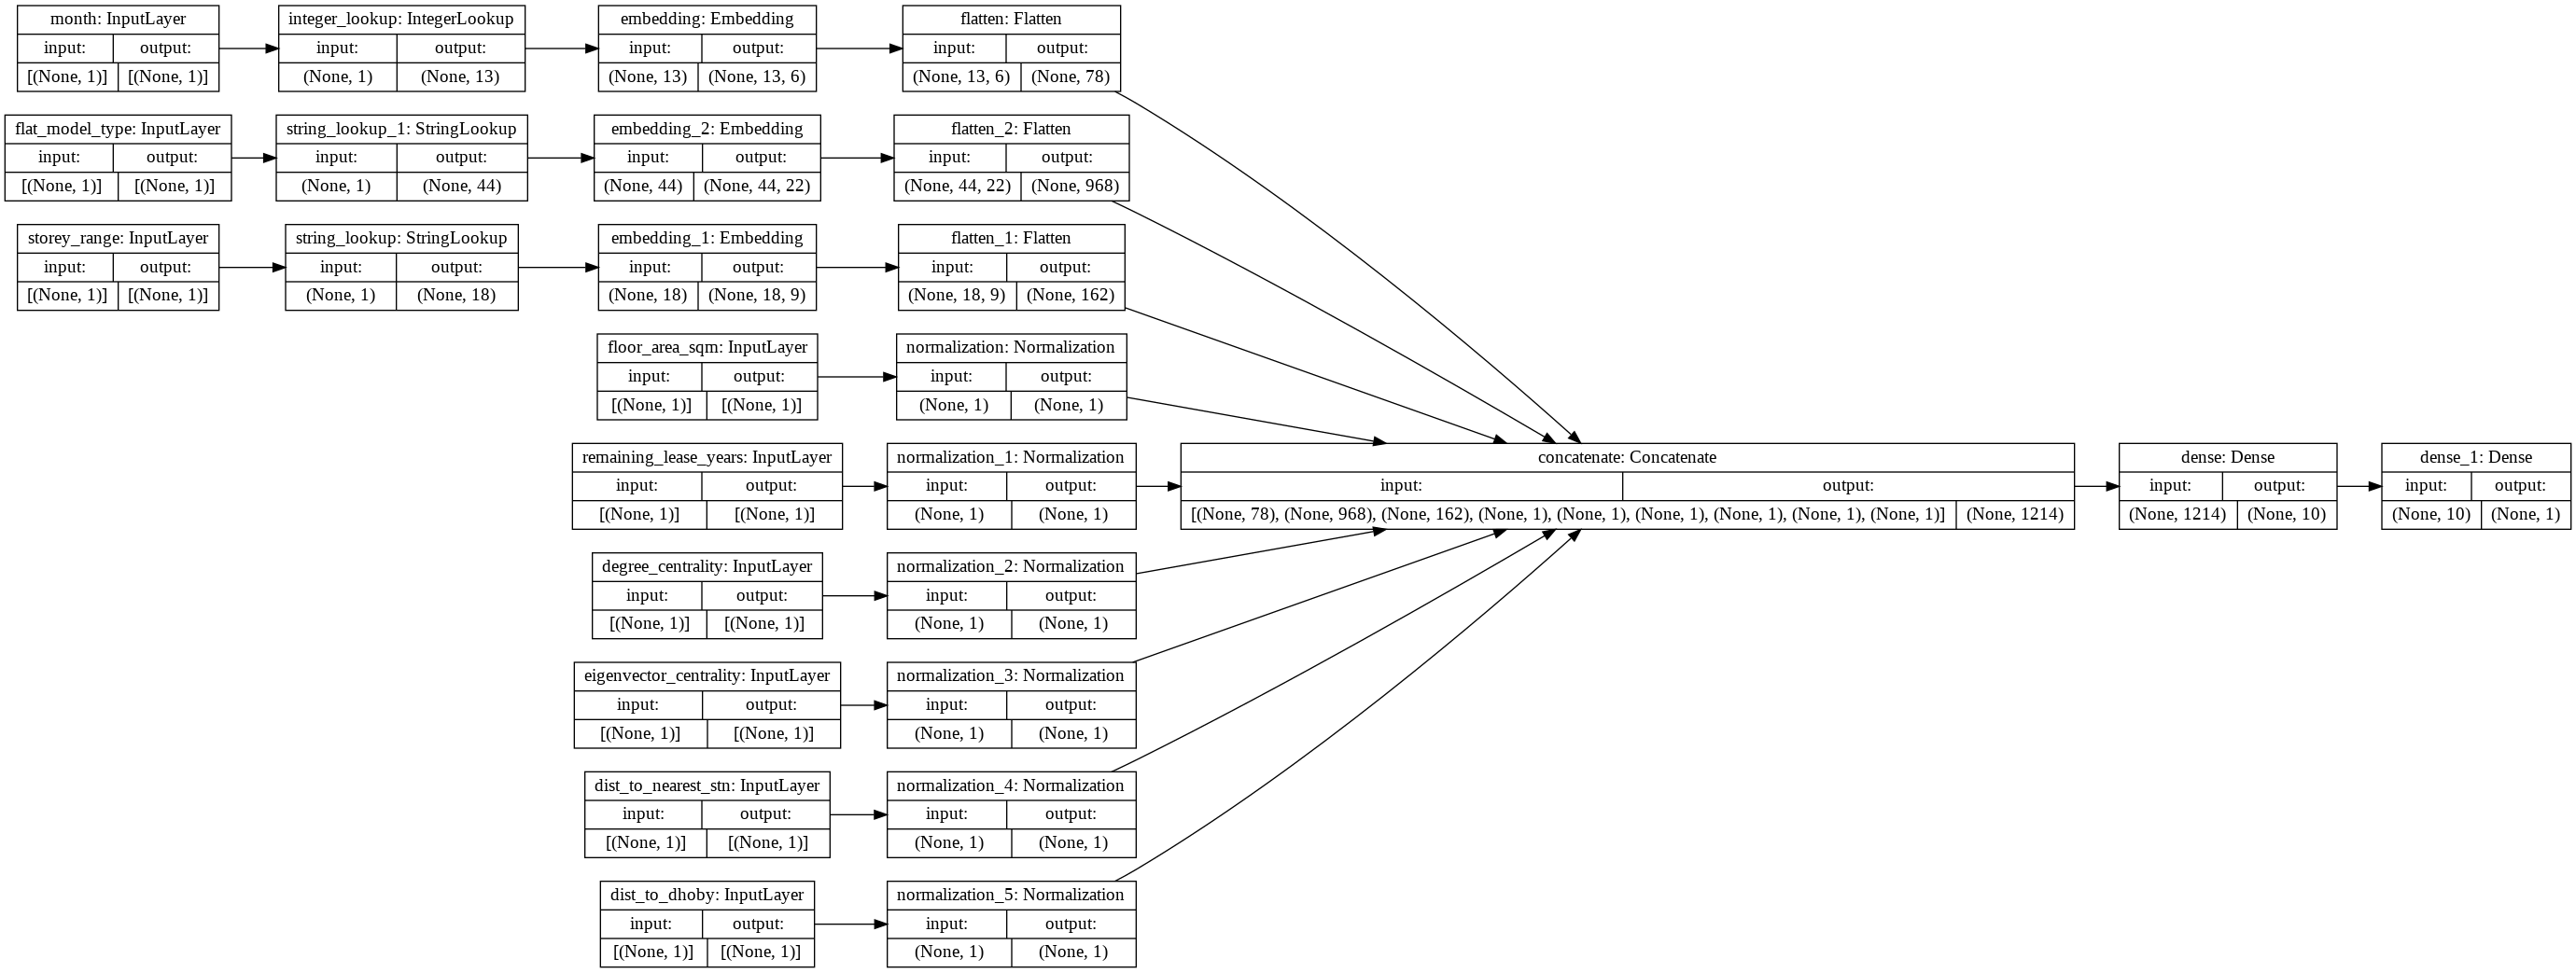

In [68]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Model Compilation

In [69]:
from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

In [70]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 7s 8ms/step - loss: 36508545024.0000 - R2: -0.5648 - val_loss: 25637201920.0000 - val_R2: 0.0134
Epoch 2/100
683/683 [==============================] - 6s 9ms/step - loss: 13506106368.0000 - R2: 0.4264 - val_loss: 12405745664.0000 - val_R2: 0.5222
Epoch 3/100
683/683 [==============================] - 6s 8ms/step - loss: 8626820096.0000 - R2: 0.6318 - val_loss: 11146994688.0000 - val_R2: 0.5689
Epoch 4/100
683/683 [==============================] - 8s 12ms/step - loss: 7497755648.0000 - R2: 0.6793 - val_loss: 8975265792.0000 - val_R2: 0.6519
Epoch 5/100
683/683 [==============================] - 6s 8ms/step - loss: 6824257536.0000 - R2: 0.7083 - val_loss: 8115778560.0000 - val_R2: 0.6854
Epoch 6/100
683/683 [==============================] - 9s 13ms/step - loss: 6169094656.0000 - R2: 0.7360 - val_loss: 8354948096.0000 - val_R2: 0.6760
Epoch 7/100
683/683 [==============================] - 6s 8ms/step - loss: 5594768896.0000 - R2: 0.7606 - val_

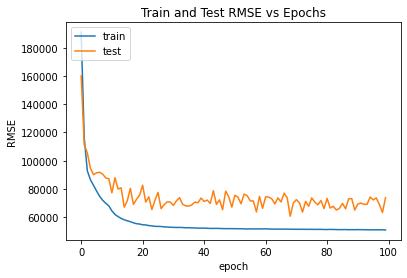

In [73]:
import math
import matplotlib.pyplot as plt

history.history['root_mean_squared_error'] = []
history.history['val_root_mean_squared_error'] = []

for i in range(len(history.history['loss'])):
    history.history['root_mean_squared_error'].append(math.sqrt(history.history['loss'][i]))

for i in range(len(history.history['val_loss'])):
    history.history['val_root_mean_squared_error'].append(math.sqrt(history.history['val_loss'][i]))

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Train and Test RMSE vs Epochs')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [74]:
test_loss = history.history['val_root_mean_squared_error']

min_epoch_loss = 0
min_loss = float("inf")
for i,loss in enumerate(test_loss):
    if loss<min_loss:
        min_loss = loss
        min_epoch_loss = i+1

print(min_epoch_loss)
print(min_loss)
print(history.history['val_R2'][min_epoch_loss-1])



69
60643.43631424591
0.8562319278717041


In [ ]:
tf.keras.backend.clear_session()
from keras import backend as K

# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model2 = keras.Model(all_inputs, output)

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model2.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

In [ ]:
history2 = model2.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
tf.keras.backend.clear_session()

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 7s 7ms/step - loss: 20073314304.0000 - R2: 0.1363 - val_loss: 12575440896.0000 - val_R2: 0.5126
Epoch 2/5
683/683 [==============================] - 6s 8ms/step - loss: 8882388992.0000 - R2: 0.6200 - val_loss: 10952161280.0000 - val_R2: 0.5760
Epoch 3/5
683/683 [==============================] - 6s 8ms/step - loss: 8591484928.0000 - R2: 0.6326 - val_loss: 10880422912.0000 - val_R2: 0.5790
Epoch 4/5
683/683 [==============================] - 6s 8ms/step - loss: 8458381312.0000 - R2: 0.6372 - val_loss: 11053998080.0000 - val_R2: 0.5711
Epoch 5/5
683/683 [==============================] - 6s 8ms/step - loss: 8309059072.0000 - R2: 0.6441 - val_loss: 10525314048.0000 - val_R2: 0.5913


In [ ]:
def build_and_train_model_question3(embeddings_list, epochs):
    all_features = layers.concatenate(embeddings_list)
    x = layers.Dense(10, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    return history


In [ ]:
import math
tf.keras.backend.clear_session()

scores = {}
history = {}

features_to_embeddings = {
    'month': month_embedder_flattened,
    'flat_model_type': flat_model_type_embedder_flattened,
    'storey_range': storey_range_embedder_flattened,
    'floor_area_sqm': floor_area_sqm_encoded,
    'remaining_lease_years': remaining_lease_years_encoded,
    'degree_centrality': degree_centrality_encoded,
    'eigenvector_centrality': eigenvector_centrality_encoded,
    'dist_to_nearest_stn': dist_to_nearest_stn_encoded,
    'dist_to_dhoby': dist_to_dhoby_encoded
}

initial_features = [
    'month',
    'flat_model_type',
    'storey_range',
    'floor_area_sqm',
    'remaining_lease_years',
    'degree_centrality',
    'eigenvector_centrality',
    'dist_to_nearest_stn',
    'dist_to_dhoby'           
]

def convert_features_list_to_embeddings(features_list):
    embeddings_list = []
    for feature in features_list:
        embeddings_list.append(features_to_embeddings[feature])
    return embeddings_list





def calculate_best_epoch_R2_and_RMSE(history):
    r2_scores = history.history['val_R2']
    mse = history.history['val_loss']
    best_epoch = 1
    for i in range(len(r2_scores)):
        if r2_scores[i]>r2_scores[best_epoch-1]:
            best_epoch = i+1
    return [r2_scores[best_epoch-1],math.sqrt(mse[best_epoch-1])]





def RFE(previous_r2_rmse_values,features_list, scores):
    if not features_list or len(features_list)==1:
        return
    print(scores)
    max_r2_score_of_children_nodes = float("-inf")
    min_rmse_of_children_nodes = float("inf")
    max_features_list = []
    for i,feature in enumerate(features_list):
        new_features_list = features_list[:i]+features_list[i+1:]
        new_embeddings_list = convert_features_list_to_embeddings(new_features_list)
        tf.keras.backend.clear_session()
        history = build_and_train_model_question3(new_embeddings_list, 5)
        r2,rmse = calculate_best_epoch_R2_and_RMSE(history)
        if r2>=max_r2_score_of_children_nodes:
            max_r2_score_of_children_nodes = r2
            min_rmse_of_children_nodes = rmse
            max_features_list = new_features_list
    prev_r2, prev_rmse = previous_r2_rmse_values
    if max_r2_score_of_children_nodes>=prev_r2:
        scores[tuple(max_features_list)] = [max_r2_score_of_children_nodes,min_rmse_of_children_nodes]
        RFE([max_r2_score_of_children_nodes,min_rmse_of_children_nodes], max_features_list, scores)

best_r2_and_rmse_score_all_features = calculate_best_epoch_R2_and_RMSE(history2)
scores[tuple(initial_features)] = best_r2_and_rmse_score_all_features
RFE(best_r2_and_rmse_score_all_features, initial_features, scores)
print(scores)
    



{('month', 'flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'degree_centrality', 'eigenvector_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby'): [0.5913466811180115, 102592.95320829788]}
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 6s 7ms/step - loss: 17120784384.0000 - R2: 0.2592 - val_loss: 11394291712.0000 - val_R2: 0.5576
Epoch 2/5
683/683 [==============================] - 6s 7ms/step - loss: 8734388224.0000 - R2: 0.6264 - val_loss: 10411074560.0000 - val_R2: 0.5969
Epoch 3/5
683/683 [==============================] - 6s 7ms/step - loss: 8487415296.0000 - R2: 0.6362 - val_loss: 10447983616.0000 - val_R2: 0.5931
Epoch 4/5
683/683 [==============================] - 6s 8ms/step - loss: 8326755328.0000 - R2: 0.6441 - val_loss: 9627022336.0000 - val_R2: 0.6269
Epoch 5/5
683/683 [==============================] - 5s 7ms/step - loss: 8069691392.0000 - R2: 0.6537 - val_loss: 9005740032.0000 - val_R2: 0.6506
Epoch 1/5
683/683 [==============================] - 5s 5ms/step - loss: 32833845248.0000 - R2: -0.4156 - val_loss: 24962971648.0000 - val_R2: 0.0326
Epoch 2/5
683/683 [==============================] - 4s 5ms/step - loss: 19942129664.0000 - R2: 0.1503 - val_loss: 241592

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f2752aaa560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 4/5
175/683 [======>.......................] - ETA: 3s - loss: 8511043584.0000 - R2: 0.6364

KeyboardInterrupt: ignored

In [ ]:
scores

{('flat_model_type',): [0.48161816596984863, 115791.62304761083],
 ('flat_model_type', 'storey_range'): [0.6089324951171875, 100497.28259012778],
 ('flat_model_type',
  'storey_range',
  'degree_centrality',
  'dist_to_nearest_stn',
  'dist_to_dhoby'): [0.6348929405212402, 97242.07155341766],
 ('flat_model_type', 'storey_range', 'dist_to_dhoby'): [0.5973911285400391,
  101965.41280257732],
 ('flat_model_type',
  'storey_range',
  'dist_to_nearest_stn',
  'dist_to_dhoby'): [0.653537929058075, 94354.76611173386],
 ('flat_model_type',
  'storey_range',
  'floor_area_sqm',
  'remaining_lease_years',
  'degree_centrality',
  'dist_to_nearest_stn',
  'dist_to_dhoby'): [0.6499189138412476, 95077.68680400254],
 ('flat_model_type',
  'storey_range',
  'floor_area_sqm',
  'remaining_lease_years',
  'degree_centrality',
  'eigenvector_centrality',
  'dist_to_nearest_stn',
  'dist_to_dhoby'): [0.6465170383453369, 95621.51523585056],
 ('flat_model_type',
  'storey_range',
  'remaining_lease_years',